In [19]:
from IPython import display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import os
import time

In [20]:
batch_size = 8
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

ds_path = "/drive0-storage/Gracia/dataset/bd"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(ds_path,
                                            seed = 123,
                                            image_size = img_size,
                                            batch_size = batch_size)

Found 4704 files belonging to 1 classes.


In [21]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder']


In [22]:
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE

In [23]:
def preprocess(image, label):
    image = tf.image.rgb_to_grayscale(image)
    image = (image-127.5)/127.5
    return image

In [24]:
with tf.device("CPU"):
    train_dataset = (
        train_ds
        .shuffle(buffer_size = BUFFER_SIZE)
        .map(preprocess, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

In [25]:
with tf.device("CPU"):
    print(len(train_dataset))
    for images in train_dataset.take(1):
        img = images[0]
        print(img.shape)  
        print(img.dtype)  
        print(np.min(img),np.max(img))  

588
(184, 216, 1)
<dtype: 'float32'>
-1.0 0.89026093


In [26]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(23*27*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((23, 27, 512)))
    assert model.output_shape == (None, 23, 27, 512) 

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 46, 54, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 92, 108, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 184, 216, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 184, 216, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[184, 216, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

with tf.device("CPU"):
    generator = make_generator_model()
    discriminator = make_discriminator_model()

# generator.summary()
# discriminator.summary()

In [27]:
# noise = tf.random.normal([1, 100])
# generated_image = generator(noise, training=False)
# plt.imshow(generated_image[0, :, :, 0], cmap='gray');

In [28]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        print(f'training epoch {epoch + 541}...')
        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 541,
                                 seed)

        # Save the model every 30 epochs
        if (epoch + 1) % 30 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 541, time.time()-start))

In [32]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(3, 3))

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./generated_images/epoch_{:04d}.png'.format(epoch))
    plt.show()

In [33]:
EPOCHS = 60
noise_dim = 100
num_examples_to_generate = 9
with tf.device("CPU"):
    seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [34]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def restore_specific_checkpoint(n):
    ckpt_path = f"./training_checkpoints/ckpt-{n}"
    checkpoint.restore(ckpt_path)
    
n = int(input('epoch number: '))
n = int(n/30)
restore_specific_checkpoint(n)

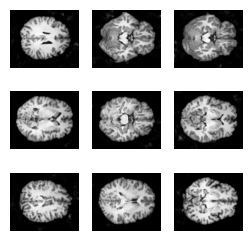

Time for epoch 600 is 72.54313373565674 sec


In [17]:
train(train_dataset, EPOCHS)

## Generate image

Generated images

<dtype: 'float32'>
-1.0 0.8675201
(184, 216, 1)


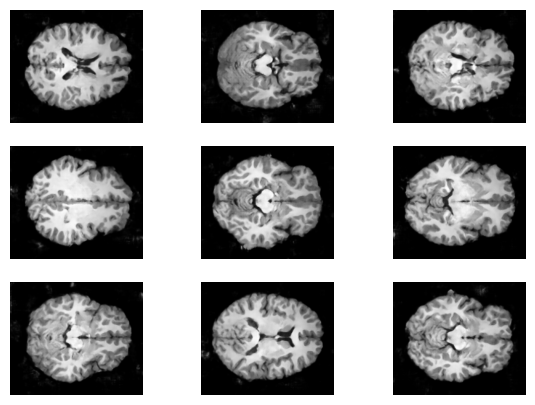

In [15]:
noise_dim = 100
num_examples_to_generate = 9

with tf.device("CPU"):
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    predictions = generator(seed, training=False)
    
plt.figure(figsize=(7,5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(predictions[i], cmap='gray')
    plt.axis("off")

test = predictions[i]
print(test.dtype)
print(np.min(test), np.max(test))
print(test.shape)

orginal dataset

<dtype: 'float32'>
0.0 208.96596
(184, 216, 3)


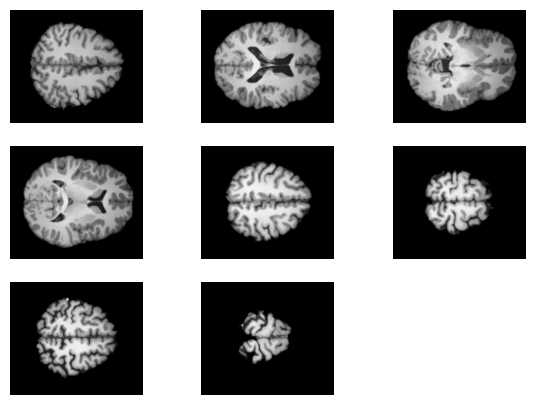

In [16]:
plt.figure(figsize=(7,5))
for images, labels in train_ds.take(1):
    org_image = images[0]
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        
print(org_image.dtype)
print(np.min(org_image), np.max(org_image))
print(org_image.shape)

processed dataset

<dtype: 'float32'>
-1.0 0.76695246
(184, 216, 1)


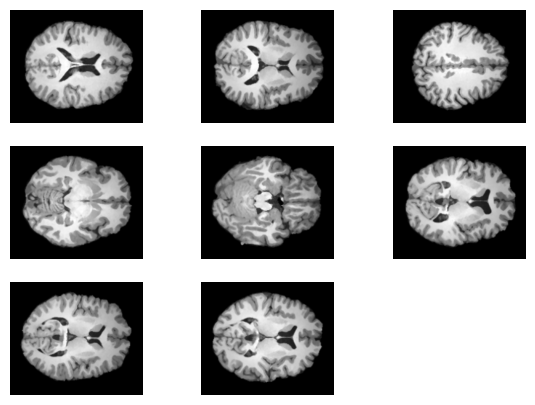

In [35]:
plt.figure(figsize=(7,5))
for images in train_dataset.take(1):
    proc_img = images[0]
    for i in range(8):
        sample = images[i]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(sample, cmap='gray')
        plt.axis("off")
        
print(proc_img.dtype)
print(np.min(proc_img), np.max(proc_img))
print(proc_img.shape)

save generated images

In [17]:
import cv2

In [18]:
## epoch 600
for j in range(16):
    noise_dim = 100
    num_examples_to_generate = 500

    with tf.device("CPU"):
        seed = tf.random.normal([num_examples_to_generate, noise_dim])
        predictions = generator(seed, training=False)
        for i in range(num_examples_to_generate):
            img = np.array(predictions[i])
            img = img/2 + 0.5
            img *= 255
            img = img.astype(np.uint8)
            cv2.imwrite(f"./generated_bd/generated_bd_{i+(j*500)}.png", img)

open image

In [91]:
im = PIL.Image.open(r"test/tes_hc0.png") 
# im = PIL.Image.open(r"dataset/hc/healthy_controls/11156_99.png") 
im = np.array(im)
print(im.dtype)
print(im.shape)
print(im.min(), im.max())

uint8
(184, 216)
0 241
